## Holmusk data
Clinical and financial data of patients hospitalized for a certain condition. Find insights about the drivers of cost of care.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR, SVR
from tqdm import tqdm
from myutils import *

data_dir = 'data/'
df_bill = pd.read_csv(data_dir+"bill_amount.csv")
df_bill_id = pd.read_csv(data_dir+"bill_id.csv")
df_demo = pd.read_csv(data_dir+"demographics.csv")
df_clinic = pd.read_csv(data_dir+"clinical_data.csv")
for df in [df_bill, df_bill_id, df_demo, df_clinic]:
    print(df.shape)
    print(df.columns)
    print('*'*20)

(13600, 2)
Index(['bill_id', 'amount'], dtype='object')
********************
(13600, 3)
Index(['bill_id', 'patient_id', 'date_of_admission'], dtype='object')
********************
(3000, 5)
Index(['patient_id', 'gender', 'race', 'resident_status', 'date_of_birth'], dtype='object')
********************
(3400, 26)
Index(['patient_id', 'date_of_admission', 'date_of_discharge',
       'medical_history_1', 'medical_history_2', 'medical_history_3',
       'medical_history_4', 'medical_history_5', 'medical_history_6',
       'medical_history_7', 'preop_medication_1', 'preop_medication_2',
       'preop_medication_3', 'preop_medication_4', 'preop_medication_5',
       'preop_medication_6', 'symptom_1', 'symptom_2', 'symptom_3',
       'symptom_4', 'symptom_5', 'lab_result_1', 'lab_result_2',
       'lab_result_3', 'weight', 'height'],
      dtype='object')
********************


# Merge data

### patient can have multiple clinical data based on admission date

In [2]:
print('Demo date repeat ids', df_demo[df_demo.duplicated(['patient_id'])].shape)
print('Clinic data repeat ids', df_clinic[df_clinic.duplicated(['patient_id'])].shape)
print('Example of repeat ids in clinical data:')
sample_repeat = df_clinic[df_clinic.duplicated(['patient_id'])]['patient_id'].iloc[0]
df_clinic[df_clinic['patient_id'] == sample_repeat]

Demo date repeat ids (0, 5)
Clinic data repeat ids (400, 26)
Example of repeat ids in clinical data:


,patient_id,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,medical_history_4,medical_history_5,medical_history_6,medical_history_7,...,symptom_1,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height
97,53e59764db1e2e8a2921d4ea65f96355,2011-03-04,2011-03-14,0,1.0,0,0,0.0,1,1,...,1,0,0,1,1,17.1,30.7,72,92.1,171
154,53e59764db1e2e8a2921d4ea65f96355,2011-04-03,2011-04-10,0,0.0,0,0,0.0,0,0,...,1,0,1,1,0,12.9,27.6,121,89.1,171


In [3]:
print('Bill id repeat id', df_bill_id[df_bill_id.duplicated(['patient_id'])].shape)
print('Bill repeat id', df_bill[df_bill.duplicated(['bill_id'])].shape)

Bill id repeat id (10600, 3)
Bill repeat id (0, 2)


In [4]:
df = pd.merge(df_demo, df_clinic, on='patient_id', how='left')
df.shape

(3400, 30)

### patient with same admission date can have multiple bills

In [5]:
df_bill_data = pd.merge(df_bill_id, df_bill, on='bill_id')
df_bill_data[df_bill_data['patient_id'] == sample_repeat]

,bill_id,patient_id,date_of_admission,amount
404,8308889464,53e59764db1e2e8a2921d4ea65f96355,2011-03-04,1243.839269
408,875758554,53e59764db1e2e8a2921d4ea65f96355,2011-03-04,4216.218917
409,7951233985,53e59764db1e2e8a2921d4ea65f96355,2011-03-04,781.166551
415,3082396846,53e59764db1e2e8a2921d4ea65f96355,2011-03-04,13735.620217
655,5971036272,53e59764db1e2e8a2921d4ea65f96355,2011-04-03,8810.508848
656,7434039316,53e59764db1e2e8a2921d4ea65f96355,2011-04-03,666.499675
658,4239685291,53e59764db1e2e8a2921d4ea65f96355,2011-04-03,648.821636
659,5601080801,53e59764db1e2e8a2921d4ea65f96355,2011-04-03,1368.355427


In [6]:
# verify sum
df_bill_data[df_bill_data['patient_id'] == sample_repeat]['amount'].sum()

31471.030539484003

In [7]:
# sum the bills
df_bill_data= df_bill_data.drop('bill_id', axis=1)
df_bill_data = df_bill_data.groupby(['patient_id','date_of_admission']).sum().reset_index()
df_bill_data.to_csv('df_bill_data.csv')

In [8]:
# join bill based on patient id and admission date
df['date_of_admission'] = pd.to_datetime(df['date_of_admission'])
df_bill_data['date_of_admission'] = pd.to_datetime(df_bill_data['date_of_admission'])
df = pd.merge(df, df_bill_data, on=['patient_id','date_of_admission'])
print(df.shape)

(3400, 31)


In [9]:
df.head(5)

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14,2014-09-20,2014-10-04,0,0.0,0,...,1,0,0,1,14.2,27.0,81,68.1,161,19564.166266
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18,2014-08-08,2014-08-18,0,0.0,No,...,1,1,1,1,14.3,27.2,92,76.5,151,20465.398960
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2011-03-10,2011-03-20,0,0.0,No,...,0,1,1,1,14.4,26.6,92,69.7,175,14435.913476
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2013-07-02,2013-07-14,0,0.0,0,...,0,0,1,0,18.0,26.6,92,66.7,175,6578.387441
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,2015-10-28,2015-11-10,0,1.0,0,...,1,1,1,1,14.9,26.7,97,96.9,180,45452.313094


In [10]:
df[df['patient_id'] == sample_repeat]

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
2048,53e59764db1e2e8a2921d4ea65f96355,Male,Chinese,Singaporean,1973-08-19,2011-03-04,2011-03-14,0,1.0,0,...,0,0,1,1,17.1,30.7,72,92.1,171,19976.844955
2049,53e59764db1e2e8a2921d4ea65f96355,Male,Chinese,Singaporean,1973-08-19,2011-04-03,2011-04-10,0,0.0,0,...,0,1,1,0,12.9,27.6,121,89.1,171,11494.185585


In [11]:
df.head(5)

,patient_id,gender,race,resident_status,date_of_birth,date_of_admission,date_of_discharge,medical_history_1,medical_history_2,medical_history_3,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
0,fa2d818b2261e44e30628ad1ac9cc72c,Female,Indian,Singaporean,1971-05-14,2014-09-20,2014-10-04,0,0.0,0,...,1,0,0,1,14.2,27.0,81,68.1,161,19564.166266
1,5b6477c5de78d0b138e3b0c18e21d0ae,f,Chinese,Singapore citizen,1976-02-18,2014-08-08,2014-08-18,0,0.0,No,...,1,1,1,1,14.3,27.2,92,76.5,151,20465.398960
2,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2011-03-10,2011-03-20,0,0.0,No,...,0,1,1,1,14.4,26.6,92,69.7,175,14435.913476
3,320aa16c61937447fd6631bf635e7fde,Male,Chinese,Singapore citizen,1982-07-03,2013-07-02,2013-07-14,0,0.0,0,...,0,0,1,0,18.0,26.6,92,66.7,175,6578.387441
4,c7f3881684045e6c49020481020fae36,Male,Malay,Singapore citizen,1947-06-15,2015-10-28,2015-11-10,0,1.0,0,...,1,1,1,1,14.9,26.7,97,96.9,180,45452.313094


In [12]:
df.describe()

,medical_history_1,medical_history_2,medical_history_4,medical_history_5,medical_history_6,medical_history_7,preop_medication_1,preop_medication_2,preop_medication_3,preop_medication_4,...,symptom_2,symptom_3,symptom_4,symptom_5,lab_result_1,lab_result_2,lab_result_3,weight,height,amount
count,3400.000000,3167.000000,3400.000000,3096.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,...,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,0.169118,0.311336,0.052059,0.063953,0.254706,0.254412,0.503824,0.591176,0.820882,0.523235,...,0.662353,0.544706,0.726471,0.526765,14.469882,27.431529,99.489706,78.748441,165.084412,21859.071130
std,0.374911,0.463113,0.222178,0.244710,0.435760,0.435594,0.500059,0.491689,0.383507,0.499533,...,0.472977,0.498071,0.445836,0.499357,1.747323,2.463844,15.254453,10.975076,6.973678,10155.336753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,9.100000,19.700000,52.000000,48.000000,151.000000,2946.100354
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,13.200000,25.800000,88.000000,71.200000,160.000000,14793.370831
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,14.500000,27.400000,100.000000,78.900000,165.000000,20180.020614
75%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,15.800000,29.100000,110.000000,86.300000,170.000000,26680.292435
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,20.300000,35.100000,150.000000,121.000000,186.000000,98723.854994


# Preprocessing

### replace values

In [13]:
# gender ['Female' 'f' 'Male' 'm']
df['gender'].replace(to_replace=['Female', 'Male'], 
                     value=['f','m'], inplace=True)

# race ['f' 'Chinese' 'm' 'Malay' 'chinese' 'Others' 'India' 'Indian']
df['race'].replace(to_replace=['chinese', 'India'], 
                   value=['Chinese','Indian'], inplace=True)

# resident_status ['Singaporean' 'Singapore citizen' 'PR' 'Foreigner']
df['resident_status'].replace(to_replace=['Singaporean'], 
                   value=['Singapore citizen'], inplace=True)

# medical_history_2 [ 0.  1. nan]
df['medical_history_2'].fillna(value=0, inplace=True)
df['medical_history_2'] = df['medical_history_2'].astype('int64')

# medical_history_3 ['0' 'No' '1' 'Yes']
df['medical_history_3'].replace(to_replace=['No', 'Yes'], 
                   value=['0','1'], inplace=True)
df['medical_history_3'] = df['medical_history_3'].astype('int64')

# medical_history_5 [ 0. nan  1.]
df['medical_history_5'].fillna(value=0, inplace=True)
df['medical_history_5'] = df['medical_history_5'].astype('int64')

# null values?
any_null(df)
redundant_col(df)

Any null values?  False
Any columns with only 1 value? 0


### add values

In [14]:
# calculate age based on admission date
df['date_of_birth'] = pd.to_datetime(df['date_of_birth'])
df['age'] = df['date_of_admission'].apply(lambda x: x.year) - df['date_of_birth'].apply(lambda x: x.year)

# calculate length of stay in days
df['duration'] = (pd.to_datetime(df['date_of_discharge']) - pd.to_datetime(df['date_of_admission'])).dt.days

In [15]:
show_unique(df)

patient_id ['fa2d818b2261e44e30628ad1ac9cc72c' '5b6477c5de78d0b138e3b0c18e21d0ae'
 '320aa16c61937447fd6631bf635e7fde' ... 'c17a0f4c4f3931bed36081fabf501396'
 'c5ca8e8bfd744a1ef6f77318bcb591b4' '20b609609d4dbb834d722ddf29f18879']
**************************************************
gender ['f' 'm']
**************************************************
race ['Indian' 'Chinese' 'Malay' 'Others']
**************************************************
resident_status ['Singapore citizen' 'PR' 'Foreigner']
**************************************************
date_of_birth ['1971-05-14T00:00:00.000000000' '1976-02-18T00:00:00.000000000'
 '1982-07-03T00:00:00.000000000' ... '1942-03-08T00:00:00.000000000'
 '1964-01-02T00:00:00.000000000' '1986-09-04T00:00:00.000000000']
**************************************************
date_of_admission ['2014-09-20T00:00:00.000000000' '2014-08-08T00:00:00.000000000'
 '2011-03-10T00:00:00.000000000' ... '2015-04-26T00:00:00.000000000'
 '2015-05-22T00:00:00.000000000' '2

# Correlation matrix

In [16]:
to_cat_codes = ['gender', 'race', 'resident_status']

for c in to_cat_codes:
    df[c] = df[c].astype('category')
    df[c+'_cat'] = df[c].cat.codes        

<IPython.core.display.Javascript object>


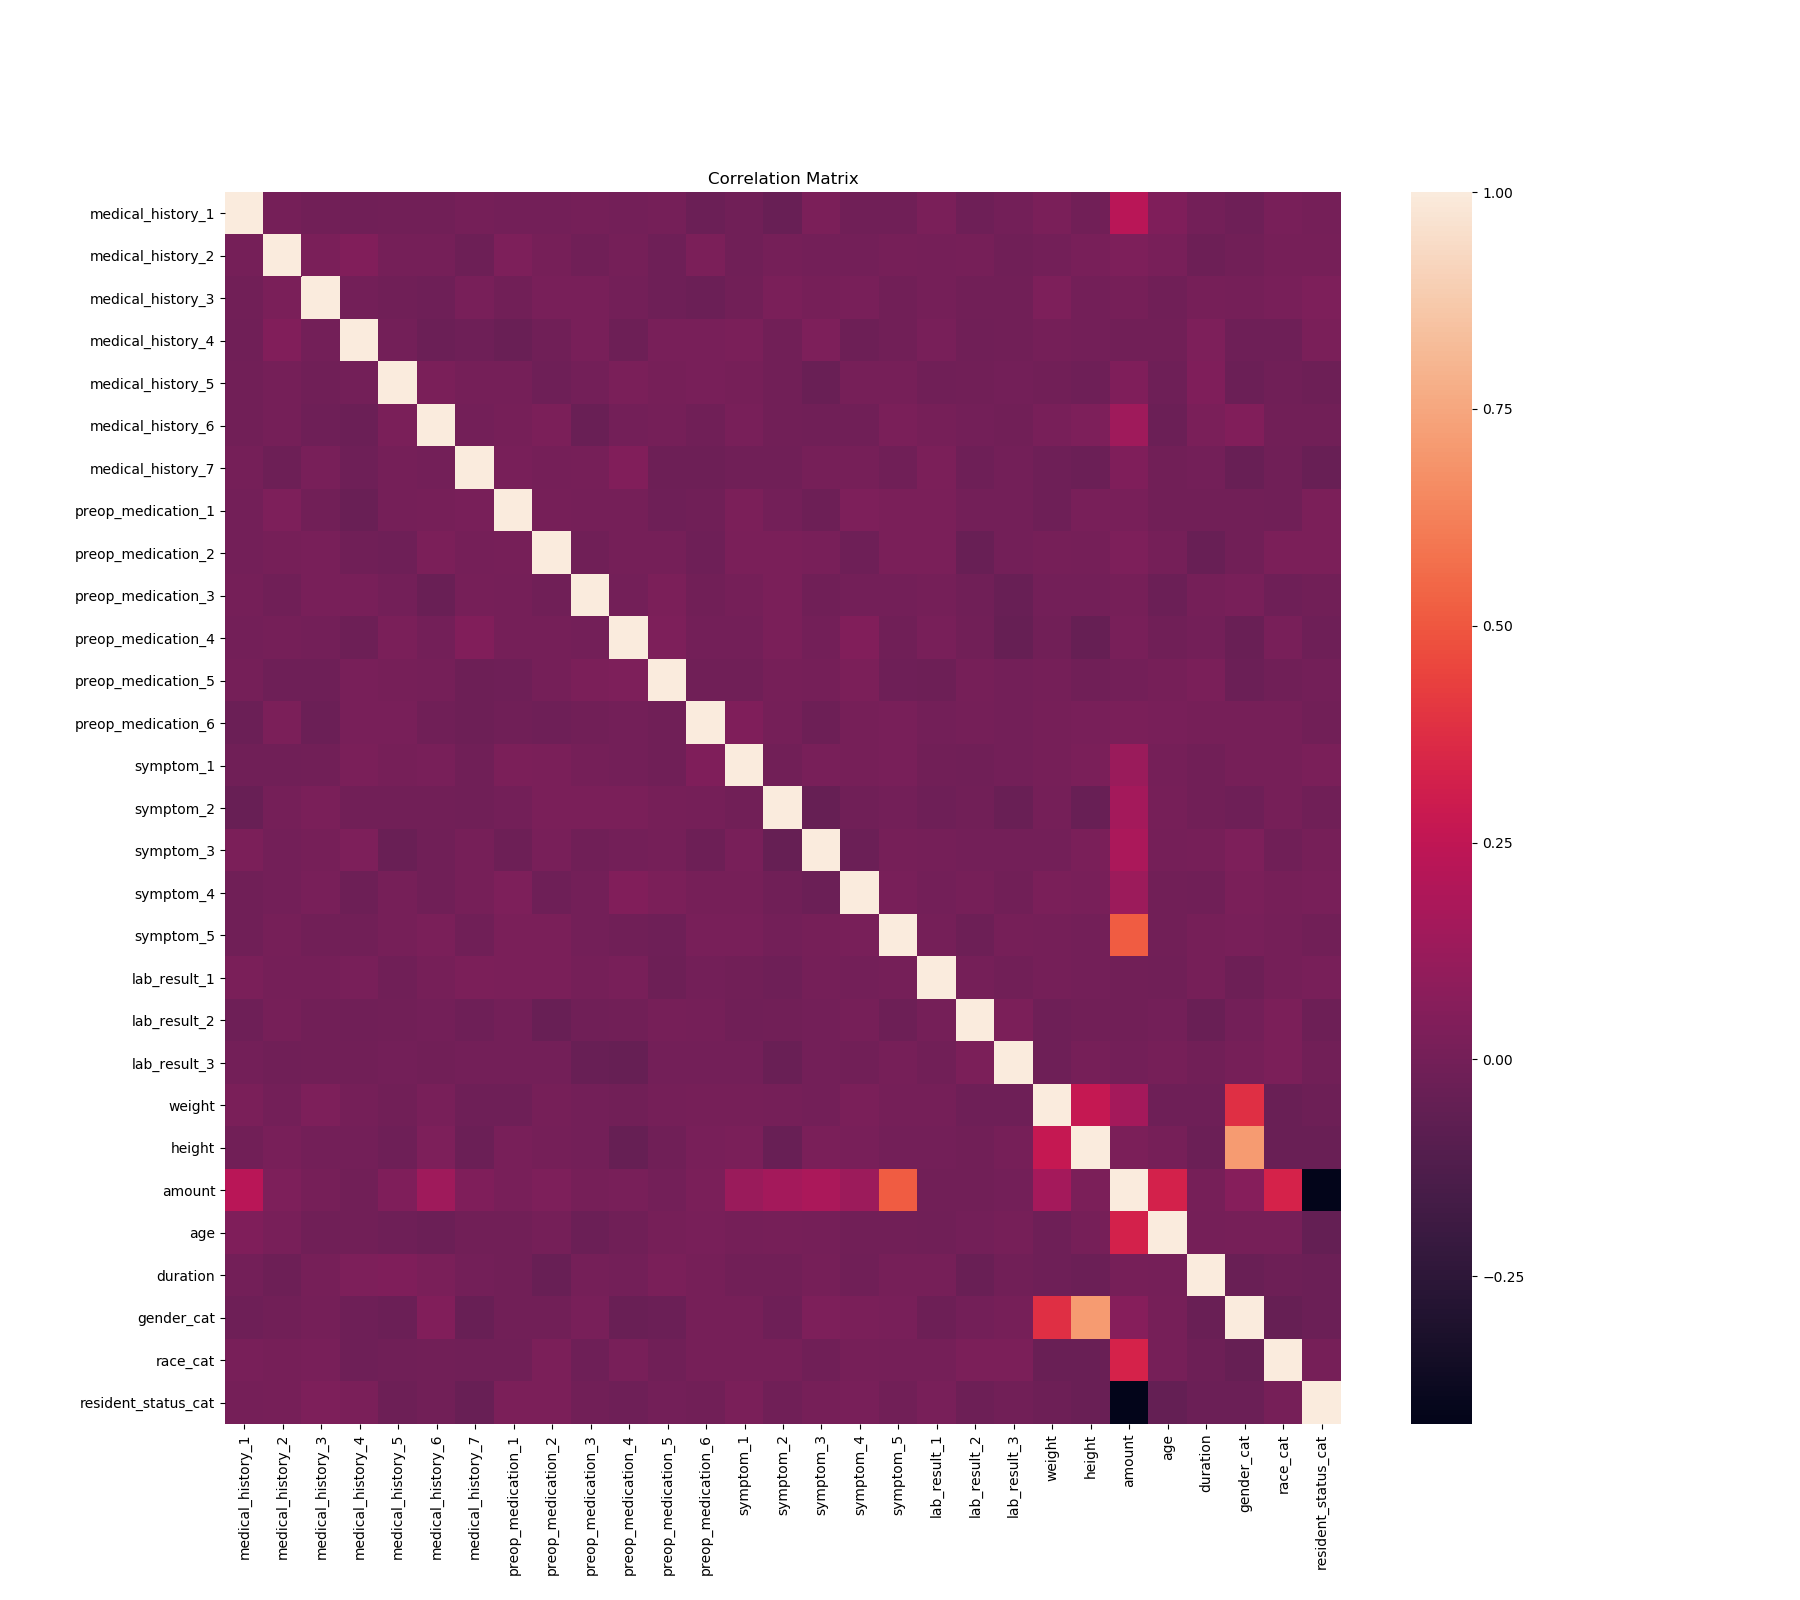

In [20]:
corr = df.corr()
plt.figure(figsize=(18,16)) 
plt.title('Correlation Matrix')
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

plt.savefig("Correlation_mat.jpg")